# Check the galactic aberration effect in the VLBI solution

In this notebook I will look at the radio source catalogs (.sou file) from a VLBI solution 
denoted as `icrf2-ga-19` and `icrf2-nga-19`.

The comparison carried out here is similar to that in the notebook `check-ga-on-icrf2` 
but all VLBI sessions up to 2019 are used.

Only the radio source positions are compared.

Three comparisons need to do done:

- `icrf2-nga-19` vs. `icrf2-ga-19`
- `icrf2-nga-19` &`icrf2-ga-19` vs. `ICRF3`
- `icrf2-nga-19` &`icrf2-ga-19` vs. `Gaia DR2`

The first comparison is to check if I can nearly reproduce the ICRF2 solution.

In [29]:
from astropy.table import Table, Column
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import bottleneck as bn

## 1 `icrf2-nga-19` vs. `icrf2-ga-19`

The two solutions are loaded from .sou files and there are **4544** sources in both solution.

In [30]:
from my_progs.vlbi.read_sou import read_sou

solnga = read_sou("../data/icrf2-nga-19/icrf2-nga-19.sou")
solga = read_sou("../data/icrf2-ga-19/icrf2-ga-19.sou")

solga

ivs_name,icrf_name,iers_name,class,ra,ra_err,dec,dec_err,ra_dec_corr,pos_err,used_obs,total_obs,used_sess,total_sess,beg_epoch,end_epoch
,,,,deg,mas,deg,mas,,mas,,,,,MJD,MJD
str8,str10,str8,str1,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64
0000+212,J0003+2129,0000+212,C,0.830625050375,0.3226783581777163,21.495696589055555,0.6656,-0.423,0.6825256087378688,66,218,2,2,50084.0,50155.0
0000-160,J0003-1547,0000-160,-,0.8636006519166668,0.10873876565082227,-15.784848738194444,0.2665,-0.355,0.26973888256141854,242,360,4,4,54817.0,58136.0
0000-197,J0003-1927,0000-197,C,0.8278126045833334,0.13521133487874482,-19.45620991238889,0.2847,-0.05,0.2848035311699863,296,357,5,5,50631.0,58136.0
0000-199,J0003-1941,0000-199,N,0.8164558467916667,0.08878215148876462,-19.697333829805554,0.2018,-0.239,0.20315601328728963,251,306,4,4,54087.0,58136.0
0001+459,J0004+4615,0001+459,C,1.0671985143333333,0.07571378788749787,46.25499185541667,0.0957,0.025,0.09574988998218706,273,276,3,3,50305.0,57835.0
0001+478,J0003+4807,0001+478,N,0.9418399315,0.2769876918520427,48.11781538775,0.3367,-0.118,0.3412005200909294,132,199,3,3,50305.0,57835.0
0001-120,J0004-1148,0001-120,C,1.0204791631666668,0.046787092382062585,-11.816218377055556,0.1021,-0.089,0.10220714296885643,308,440,5,5,50575.0,58143.0
0002+051,J0005+0524,0002+051,C,1.3342311314166666,0.21513987515425542,5.403000757055556,0.2484,0.202,0.2593428808154017,109,199,3,3,49913.0,58197.0


We can still find a  dependency of the formal uncertainties on the declination.

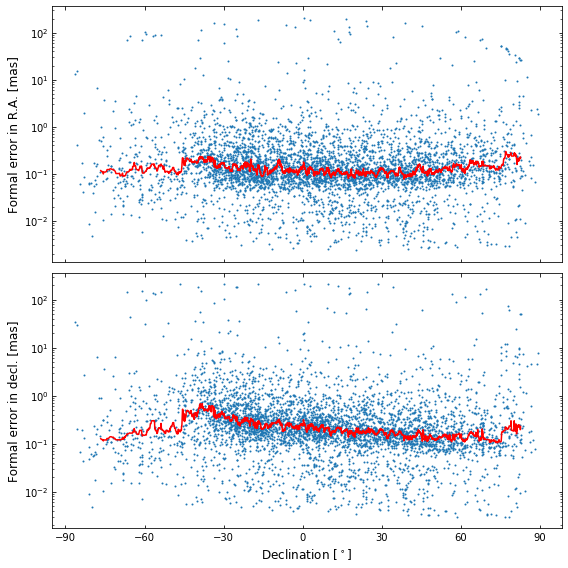

In [64]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(solga["dec"], solga["ra_err"], ".", ms=2)
ax1.plot(solga["dec"], solga["dec_err"], ".", ms=2)

# Running median 
temp = Table(solga)
temp.sort("dec")

window = 50
decmd = bn.move_median(temp["dec"], window=window)
raerrmd = bn.move_median(temp["ra_err"], window=window)
decerrmd = bn.move_median(temp["dec_err"], window=window)

ax0.plot(decmd, raerrmd, "r")
ax1.plot(decmd, decerrmd, "r")

ax0.set_yscale("log")
ax1.set_yscale("log")

ax1.set_xlabel("Declination [$^\circ$]", fontsize=12)
ax0.set_ylabel("Formal error in R.A. [mas]", fontsize=12)
ax1.set_ylabel("Formal error in decl. [mas]", fontsize=12)

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)



First we take a look at the positional offsets between these two solutions, which are purely caused by the Galactic aberration with the assumed direction and magnitude.

In [5]:
from my_progs.catalog.pos_diff import radio_cat_diff_calc

soldif = radio_cat_diff_calc(solga, solnga, sou_name="iers_name")

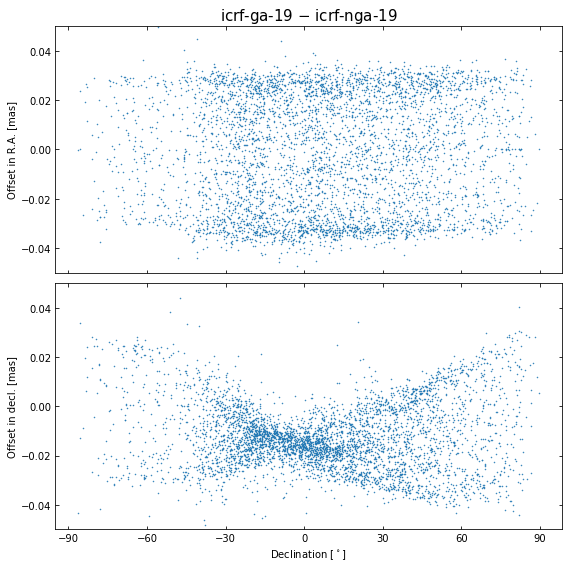

In [10]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(soldif["dec"], soldif["dra"], ".", ms=1)
ax1.plot(soldif["dec"], soldif["ddec"], ".", ms=1)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$^\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_ylim([-0.05, 0.05])
ax1.set_ylim([-0.05, 0.05])

ax0.set_title("icrf2-ga-19 $-$ icrf2-nga-19", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

The offset presents a typical GA induced pattern on the level of 25$~\mu$as.

## 2 `icrf2-nga-19` &`icrf2-ga-19` versus `ICRF3`

Then I compare these two solutions with the ICRF3 S/X catalog.

The positional offsets are similar, with little difference found by eyes.

The offset in right ascension is about 20$~\mu$as and larger than 50$~\mu$as in declination.

When modeling the global offsets, we find that `icrf2-ga-19` shows insignificant vsh terms 
while $G_y$ and $G_z$ of `icrf2-nga-19` is on the level of 20$~\mu$as.

However, the formal errors is two time greaters than the estimates.

In [54]:
from my_progs.catalog.read_icrf import read_icrf3
icrf3 = read_icrf3()

# Crossmatch between ICRF3 and solution
icrfdif1 = radio_cat_diff_calc(solnga, icrf3, sou_name="iers_name")
icrfdif2 = radio_cat_diff_calc(solga, icrf3, sou_name="iers_name")

icrfdif1.sort("dec")
icrfdif2.sort("dec")

The cross-match gives a sample of 4400 common sources.

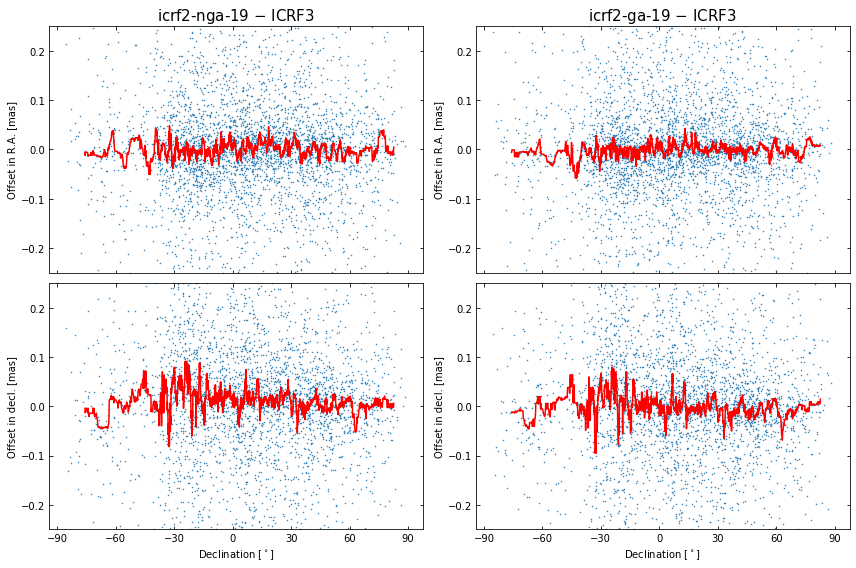

In [55]:
fig, ((ax0, ax2), (ax1, ax3)) = plt.subplots(figsize=(12, 8), 
                                             nrows=2, ncols=2,
                                             sharex=True)

ax0.plot(icrfdif1["dec"], icrfdif1["dra"], ".", ms=1)
ax1.plot(icrfdif1["dec"], icrfdif1["ddec"], ".", ms=1)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$^\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

# Running median 
temp1 = Table(icrfdif1)
temp1.sort("dec")

window = 50
decmd1 = bn.move_median(temp1["dec"], window=window)
dramd1 = bn.move_median(temp1["dra"], window=window)
ddecmd1 = bn.move_median(temp1["ddec"], window=window)

ax0.plot(decmd1, dramd1, "r")
ax1.plot(decmd1, ddecmd1, "r")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_ylim([-0.25, 0.25])
ax1.set_ylim([-0.25, 0.25])

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax0.set_title("icrf2-nga-19 $-$ ICRF3", fontsize=15)

ax2.plot(icrfdif2["dec"], icrfdif2["dra"], ".", ms=1)
ax3.plot(icrfdif2["dec"], icrfdif2["ddec"], ".", ms=1)

ax2.set_ylabel("Offset in R.A. [mas]")

ax3.set_xlabel("Declination [$^\circ$]")
ax3.set_ylabel("Offset in decl. [mas]")

# Running median 
temp2 = Table(icrfdif2)
temp2.sort("dec")

window = 50
decmd2 = bn.move_median(temp2["dec"], window=window)
dramd2 = bn.move_median(temp2["dra"], window=window)
ddecmd2 = bn.move_median(temp2["ddec"], window=window)

ax2.plot(decmd2, dramd2, "r")
ax3.plot(decmd2, ddecmd2, "r")

ax3.set_xticks(np.arange(-90, 91, 30))

ax2.set_ylim([-0.25, 0.25])
ax3.set_ylim([-0.25, 0.25])

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")
ax3.xaxis.set_ticks_position("both")
ax3.yaxis.set_ticks_position("both")

ax2.set_title("icrf2-ga-19 $-$ ICRF3", fontsize=15)

plt.subplots_adjust(hspace=0.1)

In [13]:
# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting

In [51]:
# icrf2-nga-09 - gaia dr2
# Transform columns into np.array
dra1 = np.array(icrfdif1["dra"])
ddec1 = np.array(icrfdif1["ddec"])
dra_err1 = np.array(icrfdif1["dra_err"])
ddec_err1 = np.array(icrfdif1["ddec_err"])
ra_rad1 = np.array(icrfdif1["ra"].to(u.radian))
dec_rad1 = np.array(icrfdif1["dec"].to(u.radian))
dra_ddec_cov1 = np.array(icrfdif1["dra_ddec_cov"])

# Transformation parameters
# l_max = 2
wi21, sigi21, _, _, _, _ = vsh_deg02_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1,
    cov=dra_ddec_cov1, elim_flag="None")

# mas -> uas
wi21 = wi21 * 1.e3
sigi21 = sigi21 * 1.e3

# icrf2-ga-09 - gaia dr2
# Transform columns into np.array
dra2 = np.array(icrfdif2["dra"])
ddec2 = np.array(icrfdif2["ddec"])
dra_err2 = np.array(icrfdif2["dra_err"])
ddec_err2 = np.array(icrfdif2["ddec_err"])
ra_rad2 = np.array(icrfdif2["ra"].to(u.radian))
dec_rad2 = np.array(icrfdif2["dec"].to(u.radian))
dra_ddec_cov2 = np.array(icrfdif2["dra_ddec_cov"])

# Transformation parameters
# l_max = 2
wi22, sigi22, _, _, _, _ = vsh_deg02_fitting(
    dra2, ddec2, ra_rad2, dec_rad2, dra_err2, ddec_err2,
    cov=dra_ddec_cov2, elim_flag="None")

# mas -> uas
wi22 = wi22 * 1.e3
sigi22 = sigi22 * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                            Rotation [uas]                  "
      "                                Glide [uas]               \n"
      "icrf2nga-ICRF3     x             y             z           "
      "                     x             y             z\n"
      "icrf2ga-ICRF3      x             y             z           "
      "                     x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       wi21[3], sigi21[3], wi21[4], sigi21[4], wi21[5], sigi21[5],
       wi21[0], sigi21[0], wi21[1], sigi21[1], wi21[2], sigi21[2],
       wi22[3], sigi22[3], wi22[4], sigi22[4], wi22[5], sigi22[5],
       wi22[0], sigi22[0], wi22[1], sigi22[1], wi22[2], sigi22[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])

print("icrf2nga - ICRF3")
t_quadi1 = Table([quad_names, wi21[6:], sigi21[6:]],
                 names=["Quadrupolar term", "Estimate", "Error"])
t_quadi1["Estimate"].format = "%5.0f"
t_quadi1["Error"].format = "%5.0f"
print(t_quadi1)

print("icrf2ga - ICRF3")
t_quadi2 = Table([quad_names, wi22[6:], sigi22[6:]],
                 names=["Quadrupolar term", "Estimate", "Error"])
t_quadi2["Estimate"].format = "%5.0f"
t_quadi2["Error"].format = "%5.0f"
print(t_quadi2)
In [54]:


Estimates (  4400 sources)
--------------------------------------------------------------------------------------------
                            Rotation [uas]                                                  Glide [uas]               
icrf2nga-ICRF3     x             y             z                                x             y             z
icrf2ga-ICRF3      x             y             z                                x             y             z
--------------------------------------------------------------------------------------------
          +2 +/-  51    +2 +/-  50    +3 +/-  40            +0 +/-  47   +24 +/-  46   +18 +/-  49
          +2 +/-  51    +3 +/-  50    +1 +/-  40            -2 +/-  47    -8 +/-  46    +3 +/-  49
--------------------------------------------------------------------------------------------

icrf2nga - ICRF3
Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -2    26
            EI22       -1    26
           

## 3 `icrf2-nga-19` &`icrf2-ga-19` vs. the Gaia DR2

We found **2766** common sources between icrf2-ga-19/icrf2-nga-19 and *Gaia* DR2.

Their positional differences are on the order of 0.5 mas.

And the VSH parameters agree with each other within their formal errors.

In [56]:
from my_progs.catalog.read_gaia import read_dr2_iers

gdr2 = read_dr2_iers()

# Crossmatch between Gaia DR2 and solution
gaiadif1 = radio_cat_diff_calc(solnga, gdr2, sou_name="iers_name")

gaiadif2 = radio_cat_diff_calc(solga, gdr2, sou_name="iers_name")

/usr/local/anaconda3/lib/python3.7/site-packages/bottleneck/slow/move.py:149: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nidx1 = n[idx1]
/usr/local/anaconda3/lib/python3.7/site-packages/bottleneck/slow/move.py:150: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nidx1 = nidx1 - n[idx2]
/usr/local/anaconda3/lib/python3.7/site-packages/bottleneck/slow/move.py:152: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an a

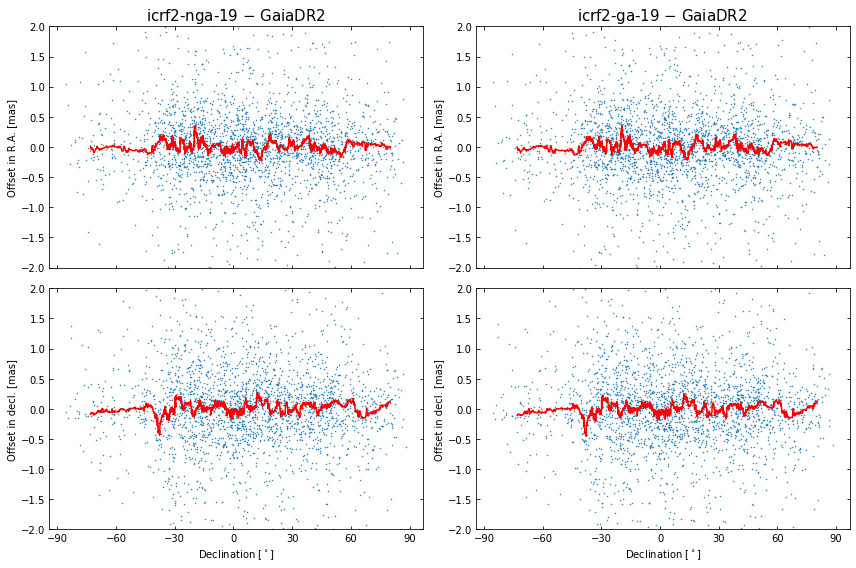

In [66]:
fig, ((ax0, ax2), (ax1, ax3)) = plt.subplots(figsize=(12, 8),
                                             nrows=2, ncols=2,
                                             sharex=True)

ax0.plot(gaiadif1["dec"], gaiadif1["dra"], ".", ms=1)
ax1.plot(gaiadif1["dec"], gaiadif1["ddec"], ".", ms=1)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$^\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

# Running median
temp1 = Table(gaiadif1)
temp1.sort("dec")

window = 50
decmd1 = bn.move_median(temp1["dec"], window=window)
dramd1 = bn.move_median(temp1["dra"], window=window)
ddecmd1 = bn.move_median(temp1["ddec"], window=window)

ax0.plot(decmd1, dramd1, "r")
ax1.plot(decmd1, ddecmd1, "r")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_ylim([-2, 2])
ax1.set_ylim([-2, 2])

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax0.set_title("icrf2-nga-19 $-$ GaiaDR2", fontsize=15)

ax2.plot(gaiadif2["dec"], gaiadif2["dra"], ".", ms=1)
ax3.plot(gaiadif2["dec"], gaiadif2["ddec"], ".", ms=1)

ax2.set_ylabel("Offset in R.A. [mas]")

ax3.set_xlabel("Declination [$^\circ$]")
ax3.set_ylabel("Offset in decl. [mas]")

# Running median
temp2 = Table(gaiadif2)
temp2.sort("dec")

window = 50
decmd2 = bn.move_median(temp2["dec"], window=window)
dramd2 = bn.move_median(temp2["dra"], window=window)
ddecmd2 = bn.move_median(temp2["ddec"], window=window)

ax2.plot(decmd2, dramd2, "r")
ax3.plot(decmd2, ddecmd2, "r")

ax3.set_xticks(np.arange(-90, 91, 30))

ax2.set_ylim([-2, 2])
ax3.set_ylim([-2, 2])

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")
ax3.xaxis.set_ticks_position("both")
ax3.yaxis.set_ticks_position("both")

ax2.set_title("icrf2-ga-19 $-$ GaiaDR2", fontsize=15)

plt.subplots_adjust(hspace=0.1)

Then the postional offsets are projected on the expensions of the vertor spherical harmonics.

In [52]:
# icrf2-nga-09 - gaia dr2
# Transform columns into np.array
dra1 = np.array(gaiadif1["dra"])
ddec1 = np.array(gaiadif1["ddec"])
dra_err1 = np.array(gaiadif1["dra_err"])
ddec_err1 = np.array(gaiadif1["ddec_err"])
ra_rad1 = np.array(gaiadif1["ra"].to(u.radian))
dec_rad1 = np.array(gaiadif1["dec"].to(u.radian))
dra_ddec_cov1 = np.array(gaiadif1["dra_ddec_cov"])

# Transformation parameters
# l_max = 2
wg21, sigg21, _, _, _, _ = vsh_deg02_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1,
    cov=dra_ddec_cov1, elim_flag="None")

# mas -> uas
wg21 = wg21 * 1.e3
sigg21 = sigg21 * 1.e3

# icrf2-ga-09 - gaia dr2
# Transform columns into np.array
dra2 = np.array(gaiadif2["dra"])
ddec2 = np.array(gaiadif2["ddec"])
dra_err2 = np.array(gaiadif2["dra_err"])
ddec_err2 = np.array(gaiadif2["ddec_err"])
ra_rad2 = np.array(gaiadif2["ra"].to(u.radian))
dec_rad2 = np.array(gaiadif2["dec"].to(u.radian))
dra_ddec_cov2 = np.array(gaiadif2["dra_ddec_cov"])

# Transformation parameters
# l_max = 2
wg22, sigg22, _, _, _, _ = vsh_deg02_fitting(
    dra2, ddec2, ra_rad2, dec_rad2, dra_err2, ddec_err2,
    cov=dra_ddec_cov2, elim_flag="None")

# mas -> uas
wg22 = wg22 * 1.e3
sigg22 = sigg22 * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "icrf2nga-GDR2     x             y             z           "
      "     x             y             z\n"
      "icrf2ga-GDR2      x             y             z           "
      "     x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       wg21[3], sigg21[3], wg21[4], sigg21[4], wg21[5], sigg21[5],
       wg21[0], sigg21[0], wg21[1], sigg21[1], wg21[2], sigg21[2],
       wg22[3], sigg22[3], wg22[4], sigg22[4], wg22[5], sigg22[5],
       wg22[0], sigg22[0], wg22[1], sigg22[1], wg22[2], sigg22[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])

print("icrf2nga - Gaia DR2")
t_quadg1 = Table([quad_names, wg21[6:], sigg21[6:]],
                 names=["Quadrupolar term", "Estimate", "Error"])
t_quadg1["Estimate"].format = "%5.0f"
t_quadg1["Error"].format = "%5.0f"
print(t_quadg1)

print("icrf2ga - Gaia DR2")
t_quadg2 = Table([quad_names, wg22[6:], sigg22[6:]],
                 names=["Quadrupolar term", "Estimate", "Error"])
t_quadg2["Estimate"].format = "%5.0f"
t_quadg2["Error"].format = "%5.0f"
print(t_quadg2)

Estimates (  4400 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
icrf2nga-GDR2     x             y             z                x             y             z
icrf2ga-GDR2      x             y             z                x             y             z
--------------------------------------------------------------------------------------------
         +40 +/-  29   -49 +/-  27    +2 +/-  27           -17 +/-  29   +79 +/-  28   +50 +/-  29
         +40 +/-  29   -47 +/-  27    -0 +/-  27           -19 +/-  29   +46 +/-  28   +35 +/-  29
--------------------------------------------------------------------------------------------

icrf2nga - Gaia DR2
Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       25    17
            EI22      -15    17
            ER21       68    32
            EI21      -40    35
    

Use a histogram to show these terms clearly.

In [46]:
from my_progs.catalog.vec_mod import vec_mod_calc

# icrf2-nga-09 - gaia dr2
gli1 = w21[:3]
rot1 = w21[3:6]
qua1 = w21[6:]

gerr1 = sig21[:3]
rerr1 = sig21[3:6]
qerr1 = sig21[6:]

glimod1, glierr1 = vec_mod_calc(gli1, gerr1)
rotmod1, roterr1 = vec_mod_calc(rot1, rerr1)

# icrf2-ga-09 - gaia dr2
gli2 = w22[:3]
rot2 = w22[3:6]
qua2 = w22[6:]

gerr2 = sig22[:3]
rerr2 = sig22[3:6]
qerr2 = sig22[6:]

glimod2, glierr2 = vec_mod_calc(gli2, gerr2)
rotmod2, roterr2 = vec_mod_calc(rot2, rerr2)

## 2.1) Rotation and Glide

In [47]:
from my_progs.catalog.vec_mod import vec_mod_calc

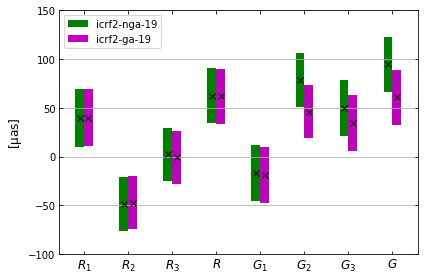

In [63]:
# Rotation
fig, ax = plt.subplots()

barwidth = 0.2
loc = 0.1

terms = ["$R_1$", "$R_2$", "$R_3$", "$R$",
         "$G_1$", "$G_2$", "$G_3$", "$G$"]

pos1 = np.arange(len(terms)) - 1 * loc
pos2 = np.arange(len(terms)) + 1 * loc

par1 = np.concatenate((rot1, [rotmod1], gli1, [glimod1]))
err1 = np.concatenate((rerr1, [roterr1], gerr1, [glierr1]))

par2 = np.concatenate((rot2, [rotmod2], gli2, [glimod2]))
err2 = np.concatenate((rerr2, [roterr2], gerr2, [glierr2]))


ax.bar(pos1, 2 * err1, bottom=par1-err1, width=barwidth,
       color="g", ecolor="black", label="icrf2-nga-19")
ax.bar(pos2, 2 * err2, bottom=par2-err2, width=barwidth,
       color="m", ecolor="black", label="icrf2-ga-19")

ax.plot(pos1, par1, "kx")
ax.plot(pos2, par2, "kx")

ax.set_xticks(range(len(terms)))
ax.set_xticklabels(terms, fontsize=12)
ax.set_ylabel("[$\\mathrm{\mu as}$]", fontsize=12)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.yaxis.grid()  # horizontal lines

ax.set_ylim(-100, 150)

ax.legend()

## 2.2) Quadruple terms

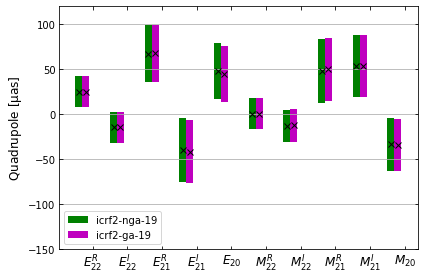

In [62]:
# Quadruple terms

fig, ax = plt.subplots()

barwidth = 0.2
loc = 0.2

terms = ["$E_{22}^R$", "$E_{22}^I$", "$E_{21}^R$", "$E_{21}^I$", "$E_{20}$",
         "$M_{22}^R$", "$M_{22}^I$", "$M_{21}^R$", "$M_{21}^I$", "$M_{20}$", ]

pos1 = np.arange(len(terms)) - 2 * loc
pos2 = np.arange(len(terms)) - 1 * loc

ax.bar(pos1, 2 * qerr1, bottom=qua1-qerr1, width=barwidth,
       color="g", ecolor="black", label="icrf2-nga-19")
ax.bar(pos2, 2 * qerr2, bottom=qua2-qerr2, width=barwidth,
       color="m", ecolor="black", label="icrf2-ga-19")

ax.plot(pos1, qua1, "kx")
ax.plot(pos2, qua2, "kx")

ax.set_xticks(range(len(terms)))
ax.set_xticklabels(terms, fontsize=12)

ax.set_ylabel("Quadrupole [$\\mathrm{\mu as}$]", fontsize=12)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.yaxis.grid()  # horizontal lines

ax.set_ylim(-150, 120)

ax.legend()

Again the results are similar to that presented in `check-ga-on-icrf2`, 
but the scatter of raido source positions with respect to the ICRF3 and Gaia DR2 catalogs.